In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import joblib
import fitsio

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# GLASS modules: cosmology and everything in the glass namespace
import glass.shells
import glass.fields
import glass.points
import glass.shapes
import glass.lensing
import glass.galaxies
import glass.observations
import glass.ext.camb

# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = 512
lmax = 1024

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0., 3., dx=200.)

In [2]:
# tophat window functions for shells
ws = glass.shells.tophat_windows(zb)

In [3]:
cls = np.load("cls200_lmax1024.npy")

In [4]:

# compute Gaussian cls for lognormal fields for 3 correlated shells
# putting nside here means that the HEALPix pixel window function is applied
gls = glass.fields.lognormal_gls(cls, nside=nside, lmax=lmax, ncorr=3)

# generator for lognormal matter fields -> converting to list for repeated use
print("Generating lognormal matter fields")
matter = glass.fields.generate_lognormal(gls, nside, ncorr=3)
matter = list(matter)

Generating lognormal matter fields


In [5]:
with open('/home/shrihan/weaklens/inhomogeneity_sims/imprint_sims/DES/DES_Data/z_sources_y3.pkl', 'rb') as f:
    ztomo = joblib.load(f)
with open('/home/shrihan/weaklens/inhomogeneity_sims/imprint_sims/DES/DES_Data/nz_sources_y3.pkl', 'rb') as f:
    nztomo = joblib.load(f)

In [6]:
# constant bias parameter for all shells
bias = 1

# ellipticity standard deviation as expected for a Stage-IV survey
sigma_all = [0.243, 0.262, 0.259, 0.301]

# Number density per bin for DES (Giulia)
n_density = [1.475584985490327, 
             1.479383426887689,
             1.483671693529899,
             1.461247850098986]


In [7]:
bin_no = 0   
print(f"Starting bin {bin_no}")

    # Get relevant sigma_e
sigma_e = sigma_all[bin_no]

# this will compute the convergence field iteratively
convergence = glass.lensing.MultiPlaneConvergence(cosmo)

# galaxy density (using 1/100 of the expected galaxy number density for Stage-IV)
n_arcmin2 = n_density[bin_no]

# true redshift distribution following a Smail distribution
z = ztomo
dndz = nztomo[bin_no] * 100
dndz *= n_arcmin2

# compute tomographic redshift bin edges with equal density
nbins = 10
zbins = glass.observations.equal_dens_zbins(z, dndz, nbins=nbins)  

# the integrated convergence and shear field over the redshift distribution
kappa_bar = np.zeros(12*nside**2) # 12 * (nside ** 2) is the number of pixels = hp.nside2npix(nside)
gamm1_bar = np.zeros(12*nside**2)
gamm2_bar = np.zeros(12*nside**2)

# simulate the matter fields in the main loop, and build up the catalogue
for i, delta_i in enumerate(matter):
    print("Running on shell", i)
    # compute the lensing maps for this shell
    convergence.add_window(delta_i, ws[i])
    kappa_i = convergence.kappa
    gamm1_i, gamm2_i = glass.lensing.shear_from_convergence(kappa_i)

    # the true galaxy distribution in this shell
    z_i, dndz_i = glass.shells.restrict(z, dndz, ws[i])

    # integrate dndz to get the total galaxy density in this shell
    ngal = np.trapz(dndz_i, z_i)

    # add to mean fields using the galaxy number density as weight
    kappa_bar += ngal * kappa_i
    gamm1_bar += ngal * gamm1_i
    gamm2_bar += ngal * gamm2_i 

# compute the overall galaxy density
ngal = np.trapz(dndz, z)

# normalise mean fields by the total galaxy number density
kappa_bar /= np.sum(ngal)
gamm1_bar /= np.sum(ngal)
gamm2_bar /= np.sum(ngal)

Starting bin 0
Running on shell 0
Running on shell 1
Running on shell 2
Running on shell 3
Running on shell 4
Running on shell 5
Running on shell 6
Running on shell 7
Running on shell 8
Running on shell 9
Running on shell 10
Running on shell 11
Running on shell 12
Running on shell 13
Running on shell 14
Running on shell 15
Running on shell 16


In [8]:
# get the angular power spectra of the lensing maps
sim_cls = hp.anafast([kappa_bar, gamm1_bar, gamm2_bar],
                    pol=True, lmax=lmax, use_pixel_weights=True)

In [9]:

# get the expected cls from CAMB
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type='lensing')]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

# get the HEALPix pixel window function, since the lensing fields have it
pw = hp.pixwin(nside, lmax=lmax)

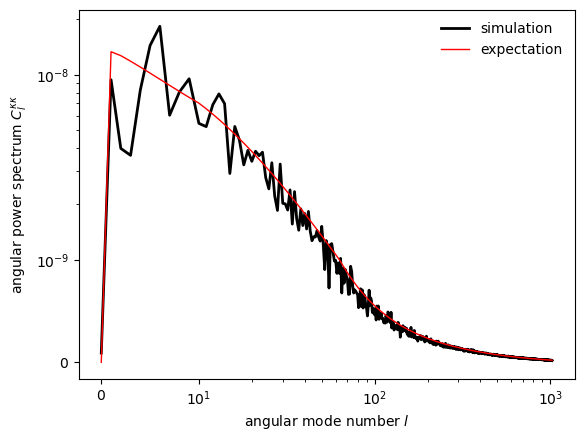

In [10]:
# plot the realised and expected cls
l = np.arange(lmax+1)
plt.plot(l, sim_cls[0], '-k', lw=2, label='simulation')
plt.plot(l, theory_cls['W1xW1']*pw**2, '-r', lw=1, label='expectation')
plt.xscale('symlog', linthresh=10, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.yscale('symlog', linthresh=1e-9, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel(r'angular mode number $l$')
plt.ylabel(r'angular power spectrum $C_l^{\kappa\kappa}$')
plt.legend(frameon=False)
plt.show()

/home/shrihan/ipykernel_2214617/2687521419.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(l, (sim_cls[0] - theory_cls['W1xW1']*pw**2) / (theory_cls['W1xW1']*pw**2), lw=2, label='resid', color='k')


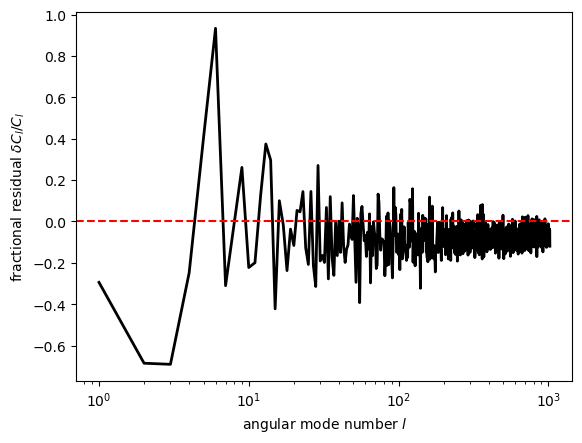

In [11]:
plt.plot(l, (sim_cls[0] - theory_cls['W1xW1']*pw**2) / (theory_cls['W1xW1']*pw**2), lw=2, label='resid', color='k')
plt.semilogx()
plt.xlabel(r'angular mode number $l$')
plt.ylabel(r'fractional residual $\delta C_l / C_l$')
plt.axhline(0, color='red', ls='--')